## Segmentation map to object location

Here I implement:

1. A transform that converts a segmentation map with $d$ dimensions into an object location map characterised by $2*d$ channels: object shift from the beginning of the origin of the cell and the object bounding box dimensions
2. A transform that calculates the necessary anchor deformation to detection an object given the bounding box description in 1 and anchors

I will probably do this as a separate and prior processing step as it can potentially become unfeasible to do it online (too time consuming for 3D).

In [1]:
import numpy as np
import nibabel as nib
import cv2
from skimage import measure
from glob import glob
from tqdm import tqdm,trange

import pylab
import matplotlib.pyplot as plt

def value_range(x):
    return x.min(),x.max()

def mask_to_bb_map(img,output_shape):
    labelled_image = measure.label(img)
    sh = np.array(labelled_image.shape)
    lsh = len(sh)
    output_sh = np.array(output_shape)
    rel_sh = sh/output_sh
    uniq = np.unique(labelled_image)
    uniq = uniq[uniq != 0]
    
    output = np.zeros([1+lsh*2,*output_sh])
    for u in uniq:
        C = np.where(labelled_image == u)
        bb = np.array([value_range(c) for c in C])
        center = np.mean(bb,1)
        bb_out = bb/sh[:,np.newaxis]
        center_out = center/rel_sh
        center_coords = np.floor(center_out)
        center_adj = center_out - center_coords
        center_coords = np.int32(center_coords)
        bb_dimensions = bb_out[:,1] - bb_out[:,0]
        E = np.concatenate([[1],center_adj,bb_dimensions])

        if len(C) == 2:
            output[:,center_coords[0],center_coords[1]] = E
        elif len(C) == 3:
            c = center_coords
            output[:,c[0],c[1],c[2]] = E
    
    return output

def mask_to_bb(img:np.ndarray)->list:
    labelled_image = measure.label(img)
    uniq = np.unique(labelled_image)
    uniq = uniq[uniq != 0]
    
    bb_vertices = []
    c = []
    for u in uniq:
        C = np.where(labelled_image == u)
        bb = np.array([value_range(c) for c in C])
        if np.all(bb[:,1] == bb[:,0]) == False:
            bb_vertices.append(bb)
            c.append(np.median(img[C]))

    return bb_vertices,c

def bb_mask_to_coords(img,shape):
    reconstructed_centers = []
    reconstructed_dimensions = []
    sh = np.array(img.shape)[1:]
    lsh = sh.size
    shape = np.array(shape)
    rel_sh = shape/sh
    centers = np.array(np.where(img[0,:,:] > 0)).T
    for center in centers:

        center_map = output[1:(1+lsh)]
        center_adj = [x[tuple(center)] for x in center_map]
        center_rec = np.array((center + center_adj).T*rel_sh)
        reconstructed_centers.append(center_rec)

        bb_map = output[(1+lsh):]
        bb_dim_rec = np.array([x[tuple(center)] for x in bb_map])
        bb_dim_rec = bb_dim_rec * shape
        reconstructed_dimensions.append(bb_dim_rec)

    return reconstructed_centers,reconstructed_dimensions

In [2]:
label_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/Prostatex0100_T2WAx_aggregated.nii.gz"

label_image = nib.load(label_path).get_fdata()

A = 100
x,y,z = np.where(label_image>0)
label_image[x-A,y-A,z] = 1
label_image[x+A,y+A,z] = 1

### Segmentation mask to bounding box and back (2D case)

The functions in the code block above have been generalized and work equally well in 2D and 3D. First I apply them to a 2D image.

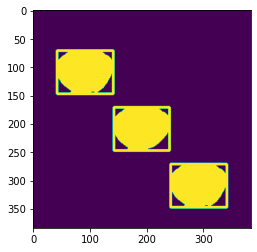

In [3]:
X = label_image[:,:,8]

img = X
output_shape = [32,32]

output = mask_to_bb_map(img,output_shape)
rec_centers,rec_dims = bb_mask_to_coords(output,X.shape)

image_plot = np.uint8(X[:,:].T).copy()
for rec_center,rec_dim in zip(rec_centers,rec_dims):
    upper_corner = tuple(np.int32(rec_center - rec_dim/2))
    lower_corner = tuple(np.int32(upper_corner + rec_dim))
    cv2.rectangle(
        image_plot,upper_corner[:2],lower_corner[:2],(1),3)

plt.imshow(image_plot)

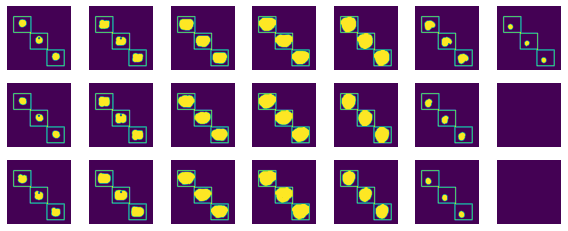

In [4]:
pylab.rcParams['figure.figsize'] = (10.0, 4.0)

X = label_image

img = X
output_shape = [32,32,20]

output = mask_to_bb_map(img,output_shape)
rec_centers,rec_dims = bb_mask_to_coords(output,X.shape)

div = 3
g,ax = plt.subplots(div,int(np.ceil(X.shape[-1]/div)))
for i in range(X.shape[-1]):
    image_plot = np.uint8(X[:,:,i].T).copy()
    for rec_center,rec_dim in zip(rec_centers,rec_dims):
        upper_corner = tuple(np.int32(rec_center - rec_dim/2))
        lower_corner = tuple(np.int32(upper_corner + rec_dim))
        if upper_corner[-1] <= i and lower_corner[-1] >= i:
            cv2.rectangle(
                image_plot,upper_corner[:2],lower_corner[:2],(1),3)

    ax[i%div,int(i//div)].imshow(image_plot)
    ax[i%div,int(i//div)].set_axis_off()

plt.show()

### Bounding box map and anchors to adjusted anchors and back

Given a set of anchors - otherwise known as bounding box priors - at each position in the bounding box map, we can calculate the amount of necessary (rigid and anysotropic) deformation necessary to resize them. Since I know (beforehand) that the prostate, for the images above, is supposed to be $\approx[100,100,18]$, I set two different anchors - $[90,90,14]$ and $[110,110,20]$. 

As such, at each individual pixel/voxel, there is an anchor which contains or not the prostate (the object). This measure of object colocation - also known as the anchor's "objectness" - is calculated as the overlap between an anchor and the bounding box of an object as measured by the intersection over the union (IoU) between both. Below a given threshold (let's assume $IoU < 0.5$) I assume that the anchor does not capture the box. For any other case ($IoU \geq 0.5$) I assume the anchor captures the object. My intention is to do all anchor calculations and adjustments online.

The simples way to calculate the IoU between two non-rotated bounding boxes is to:
1. Describe each bounding box as two of its vertices ($v_{min}$ as the top left vertex and $v_{max}$ as the bottom right vertex)
2. Calculate the vertices of the intersection box (the maximum coordinate values for both $v_{min}$ and the minimum coordinate values for $v_{max}$)
3. Calculate the area of the intersection box and of both bounding boxes (the bounding box dimensions can be used for this)
4. Calculate the ratio between the intersection (area of the intersection box) and the union ($\mathrm{area}_1 + \mathrm{area}_2 - \mathrm{area_{intersection}}$)

For this application (calculating IoU between an arbitrary number of anchors and bounding boxes), rather than a bounding box map, it is more practical to have an array of bounding boxes in long format. 

The outcome of this process is a set of positive anchors which fulfill the following set of criteria:

1. $IoU \geq 0.5$
2. $\mathrm{Distance}(\mathrm{object\ center},\mathrm{anchor\ center}) \leq 1$

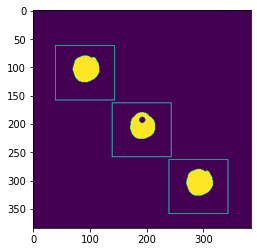

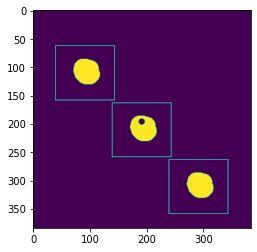

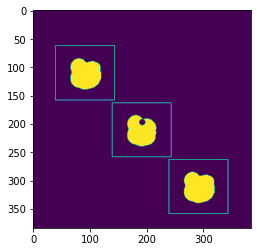

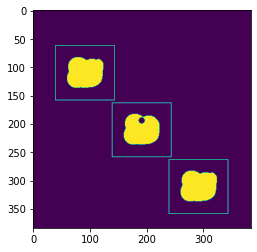

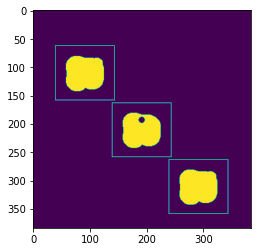

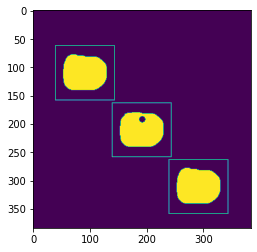

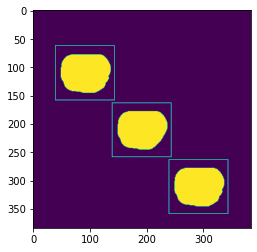

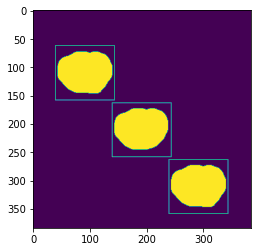

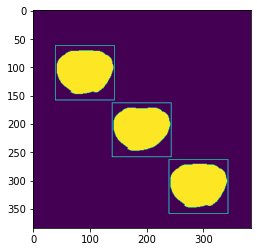

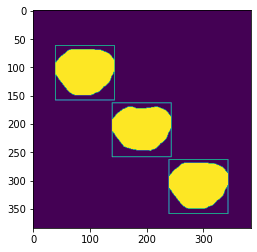

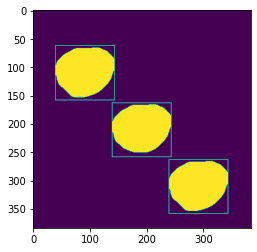

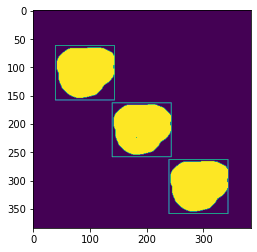

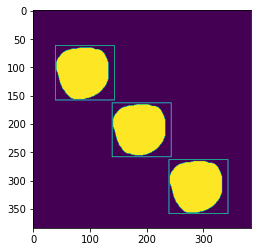

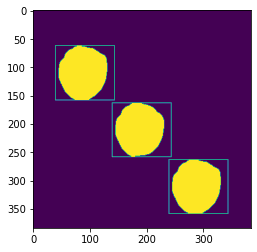

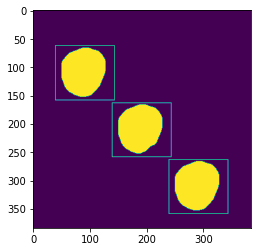

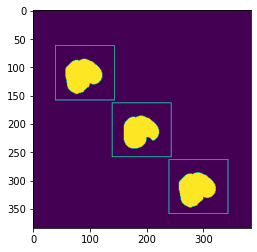

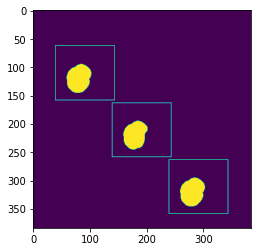

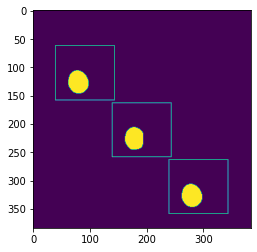

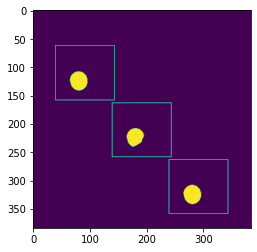

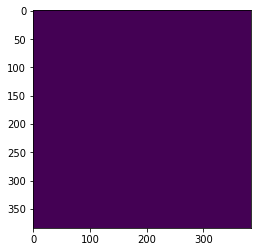

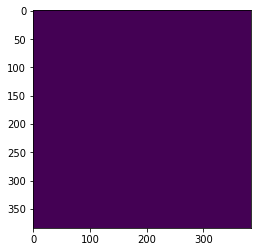

In [5]:
from itertools import product

class MaskToAdjustedAnchors:
    def __init__(self,anchor_sizes,input_sh,output_sh,iou_thresh):
        self.anchor_sizes = [np.array(x) for x in anchor_sizes]
        self.input_sh = input_sh
        self.output_sh = np.array(output_sh)
        self.iou_thresh = iou_thresh

        self.setup_long_anchors()
    
    def setup_long_anchors(self):
        image_sh = np.array(self.input_sh)
        self.rel_sh = image_sh / self.output_sh

        long_coords = []
        for c in product(
            *[np.arange(x) for x in self.output_sh]):
            long_coords.append(c)

        self.long_coords = np.array(long_coords)
        rel_anchor_sizes = [x/self.rel_sh
                            for x in self.anchor_sizes]

        self.long_anchors = []
        for rel_anchor_size in rel_anchor_sizes:
            # adding 0.5 centres the bounding boxes in each cell
            long_anchor_rel = [
                long_coords-rel_anchor_size/2 + 0.5,
                long_coords+rel_anchor_size/2 + 0.5]
            self.long_anchors.append(
                np.stack(long_anchor_rel,axis=-1))

    def __call__(self,bb_vertices,classes):
        bb_vertices = np.array(bb_vertices)
        rel_bb_vert = bb_vertices / self.rel_sh[
            np.newaxis,:,np.newaxis]
        output = np.zeros([8*len(self.long_anchors),*self.output_sh])
        for I,long_anchor in enumerate(self.long_anchors):
            anchor_size = long_anchor[0,:,1] - long_anchor[0,:,0]
            for i in range(rel_bb_vert.shape[0]):
                cl = classes[i]
                rel_bb_size = np.subtract(
                    rel_bb_vert[i,:,1],
                    rel_bb_vert[i,:,0])
                rel_bb_size_adj = rel_bb_size/anchor_size
                center = np.mean(
                    rel_bb_vert[i,:,:],axis=-1)
                intersects = np.logical_and(
                    np.all(
                        long_anchor[:,:,1]>rel_bb_vert[i,:,0],axis=1),
                    np.all(
                        long_anchor[:,:,0]<rel_bb_vert[i,:,1],axis=1))
                inter_tl = np.maximum(
                    long_anchor[:,:,0],rel_bb_vert[i,:,0])
                inter_br = np.minimum(
                    long_anchor[:,:,1],rel_bb_vert[i,:,1])
                inter_dim = inter_br - inter_tl
                inter_vol = np.prod(inter_dim,axis=-1)
                anchor_dim = long_anchor[:,:,1]-long_anchor[:,:,0]
                bb_dim = np.subtract(
                    rel_bb_vert[i:(i+1),:,1],
                    rel_bb_vert[i:(i+1),:,0])
                anchor_vol = np.prod(anchor_dim,axis=-1)
                bb_vol = np.prod(bb_dim,axis=-1)
                vol_union = anchor_vol+bb_vol-inter_vol
                iou = inter_vol / vol_union
                intersection_idx = np.logical_and(
                    iou>self.iou_thresh,intersects)
                box_coords = self.long_coords[intersection_idx]
                iou = iou[intersection_idx]

                center_adjustment = center-(box_coords+0.5)
                distance_idx = np.all(np.abs(center_adjustment) < 1,axis=1)

                iou = iou[distance_idx]
                box_coords = box_coords[distance_idx]
                center_adjustment = center_adjustment[distance_idx]

                for j in range(box_coords.shape[0]):
                    idx = tuple(
                        [tuple([k+I*len(self.long_anchors) for k in range(8)]),
                         *box_coords[j]])
                    v = np.array(
                        [iou[j],*center_adjustment[j],*rel_bb_size_adj,cl])
                    output[idx] = v

        return output
    
    def adjusted_anchors_to_bb_vertices(self,anchor_map):
        top_left_output = []
        bottom_right_output = []
        for i in range(len(self.anchor_sizes)):
            anchor_size = anchor_sizes[i]
            rel_anchor_size = np.array(anchor_size)
            sam = anchor_map[(i*8):(i*8+8)]
            coords = np.where(sam[0]>0)
            adj_anchors_long = np.zeros([len(coords[0]),7])
            for j,coord in enumerate(zip(*coords)):
                center_idxs = tuple([tuple([k for k in range(7)]),*coord])
                v = sam[center_idxs]
                adj_anchors_long[j,:] = v
            correct_centers = np.add(
                adj_anchors_long[:,1:4]+0.5,np.stack(coords,axis=1))
            correct_centers = correct_centers * self.rel_sh
            correct_dims = np.multiply(
                adj_anchors_long[:,4:],rel_anchor_size)
            top_left = correct_centers - correct_dims/2
            bottom_right = correct_centers + correct_dims/2
            top_left_output.append(top_left)
            bottom_right_output.append(bottom_right)
        return top_left_output,bottom_right_output

output_sh = [32,32,10]
anchor_sizes = [[90,90,14],[110,110,20],[100,100,18]]
iou_thresh = 0.5
bb_vertices,classes = mask_to_bb(label_image)

input_sh = label_image.shape
m = MaskToAdjustedAnchors(anchor_sizes[0:1],input_sh,output_sh,iou_thresh)
output = m(bb_vertices,classes)
O = m.adjusted_anchors_to_bb_vertices(anchor_map=output)

top_left_v,bottom_right_v = O

for dim in range(label_image.shape[-1]):
    d = np.uint8(label_image[:,:,dim].T)
    for i in range(len(top_left_v)):
        tlvs = top_left_v[i]
        brvs = bottom_right_v[i]
        for tlv,brv in zip(tlvs,brvs):
            tlv = np.int32(tlv)
            brv = np.int32(brv)
            if tlv[2] <= dim and brv[2] >= dim:
                cv2.rectangle(d,tuple(tlv[:2]),tuple(brv[:2]),1)
    plt.imshow(d)
    plt.show()

### Benchmarking - is online feasible?

The final step is assessing whether it is feasible to perform this online (i.e. during training) without adding significant overhead. Firstly I have to check the following: 

* What is the size distribution of objects? This will affect anchor number and dimension
* What is the object distance distribution (particularly between lesions)? This will affect the dimension of the output map

To assess both of these issues I make use of the available ProstateX data.

In [6]:
mask_paths = {
    "gland":{
        "T2WAx":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/*T2WAx*.nii.gz"),
        "DWI": glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-gland/*DWI*.nii.gz")},
    "lesion":{
        "T2WAx":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/*T2WAx*.nii.gz"),
        "DWI":glob(
            "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/*DWI*.nii.gz")}}
all_input_sh = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}
all_masks = {"gland":{"T2WAx":[],"DWI":[]},
             "lesion":{"T2WAx":[],"DWI":[]}}
for region in mask_paths:
    for mod in mask_paths[region]:
        print(region,mod)
        for path in tqdm(mask_paths[region][mod]):
            f = nib.load(path).get_fdata()
            bb,c = mask_to_bb(f)
            all_masks[region][mod].append([bb,c])
            all_input_sh[region][mod].append(f.shape)

gland T2WAx


100%|██████████| 179/179 [00:30<00:00,  5.89it/s]


gland DWI


100%|██████████| 175/175 [00:01<00:00, 106.49it/s]


lesion T2WAx


100%|██████████| 179/179 [00:30<00:00,  5.91it/s]


lesion DWI


100%|██████████| 175/175 [00:01<00:00, 114.58it/s]


In [7]:
sizes = {"gland":{"T2WAx":[],"DWI":[]},
         "lesion":{"T2WAx":[],"DWI":[]}}
distances = {"gland":{"T2WAx":[],"DWI":[]},
             "lesion":{"T2WAx":[],"DWI":[]}}
shapes = {"gland":{"T2WAx":[],"DWI":[]},
          "lesion":{"T2WAx":[],"DWI":[]}}
for region in all_masks:
    for mod in all_masks[region]:
        shapes[region][mod] = np.median(
            all_input_sh[region][mod],axis=0)
        for bb,c in all_masks[region][mod]:
            if len(bb) > 0:
                bb = np.array(bb)
                diff = bb[:,:,1] - bb[:,:,0] + 1
                sizes[region][mod].extend([x for x in diff])

                n = bb.shape[0]
                if n > 1:
                    for i in range(n):
                        for j in range(n):
                            if i != j:
                                Ds = []
                                for v in [0,1]:
                                    D = np.abs(bb[i,:,v]-bb[j,:,v])
                                    Ds.append(D)
                                D = np.array(Ds)
                                D = D[D.sum(1).argmin()]
                                distances[region][mod].append(D)

In [8]:
size_clusters = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}
minimum_distances = {
    "gland":{"T2WAx":[],"DWI":[]},
    "lesion":{"T2WAx":[],"DWI":[]}}

from sklearn.cluster import OPTICS,KMeans

def infer_anchor_sizes(size_array,clust):
    sc = []
    s = np.array(size_array)
    x = clust.fit_predict(s.astype(np.float32))
    for c in np.unique(x):
        centroid = np.median(s[x == c],0)
        sc.append(centroid)
    return sc

def infer_min_distance(distance_array):
    d = np.array(distance_array)
    return d[d.sum(1).argmin()]

clust = OPTICS(min_samples=10)
clust = KMeans(n_clusters=15)
for region in sizes:
    for mod in sizes[region]:
        size_array = np.array(sizes[region][mod])
        size_array = size_array[np.prod(size_array,1)>9]
        sc = infer_anchor_sizes(size_array,clust)
        size_clusters[region][mod] = sc
        if region == "lesion":
            md = infer_min_distance(distances[region][mod])
            minimum_distances[region][mod] = md

print(size_clusters)

{'gland': {'T2WAx': [array([104.,  88.,  14.]), array([124., 122.,  19.]), array([117. , 105. ,  16.5]), array([86. , 69.5, 11. ]), array([130., 148.,  21.]), array([112.,  78.,  12.]), array([140., 115.,  19.]), array([155. , 150. ,  20.5]), array([106.5,  99. ,  16.5]), array([118.,  92.,  15.]), array([126.5, 105.5,  17.5]), array([95., 75., 12.]), array([97.5, 65. , 10.5]), array([146.5, 130.5,  21. ]), array([131.,  92.,  16.])], 'DWI': [array([32., 26., 16.]), array([105., 104.,  19.]), array([26., 19., 13.]), array([37.5, 39. , 19. ]), array([27. , 22.5, 16. ]), array([33., 33., 19.]), array([26., 22., 13.]), array([31. , 21.5, 12.5]), array([23. , 19. , 12.5]), array([35., 29., 19.]), array([29. , 26.5, 17. ]), array([29., 25., 14.]), array([31. , 23. , 16.5]), array([29.5, 32. , 17. ]), array([32., 27., 18.])]}, 'lesion': {'T2WAx': [array([32., 21.,  3.]), array([8., 8., 1.]), array([58., 48.,  8.]), array([17., 22.,  3.]), array([37., 45.,  5.]), array([19., 16.,  3.]), array

In [9]:
import time
for region in size_clusters:
    for mod in size_clusters[region]:
        input_sh = shapes[region][mod].astype(np.int32)
        anchors = size_clusters[region][mod]
        m = minimum_distances[region][mod]
        if len(m) == 0:
            output_sh = {
                "T2WAx":[32,32,10],"DWI":[16,16,10]}[mod]
        else:
            M = np.max(minimum_distances[region][mod])
            output_sh = np.int32(input_sh / M)
        times = []
        for _ in trange(10):
            m = MaskToAdjustedAnchors(anchor_sizes,input_sh,output_sh,iou_thresh)
            for bb_vertices,c in all_masks[region][mod]:
                if len(bb_vertices) > 0:
                    a = time.time()
                    output = m(bb_vertices,c)
                    b = time.time()
                    times.append(b-a)

        print(region,mod,output_sh)
        print('\t',np.mean(times),np.quantile(times,[0.,0.25,0.5,0.75,1.0]))

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


gland T2WAx [32, 32, 10]
	 0.003562925780951644 [0.00322175 0.003434   0.00351763 0.00358558 0.00993681]


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


gland DWI [16, 16, 10]
	 0.0009764325278145927 [0.00094366 0.00095057 0.0009675  0.00098443 0.00190496]


100%|██████████| 10/10 [00:41<00:00,  4.20s/it]


lesion T2WAx [96 96  5]
	 0.022669495284224357 [0.01470113 0.01513767 0.01548505 0.02888018 0.08084273]


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

lesion DWI [21 32  4]
	 0.001465547906941381 [0.0009799  0.00099397 0.00102592 0.00195324 0.00412703]


At an approximate time of $\approx 0.023s$ for the largest prediction map, it appears to be feasible to render anchor boxes online.

### Implementing a three dimensional NMS

Currently there is no publically available implementation of NMS for 3D images in PyTorch. For this reason I implement a generalization of the NMS algorithm for n-dimensional cases. In short, the algorithm is as follows, given an $N*2n$-sized array for bounding box corners and an $N$-sized array of scores:

1. Calculate the reverse order of the scores (`argsort`)
2. Sort the bounding boxes and scores according to this order (higher score to lowest)
3. Remove all bounding boxes and scores falling below a given `score_threshold`
4. Iterate over all bounding boxes and calculate the IoU with all remaining boxes. If the IoU between the reference box $R$ and another box $O$ is superior to a given `iou_threshold`, $O$ is removed as it has a smaller confidence score (consquence of sorting the bounding boxes by confidence score)
5. Return all boxes that survived step 4

By operating in this way and through the use of array indexing, we can be sure to only make a single pass and eliminate all lower confidence overlapping boxes.

A small benchmarking reveals this scales linearly, with an approximate time per bounding box of $\approx 0.0003s$.

In [73]:
import torch
import numpy as np
import time
import torchvision

import matplotlib.pyplot as plt

def check_overlap(bb1:torch.Tensor,bb2:torch.Tensor,ndim:int=3)->torch.Tensor:
    return torch.logical_and(
        torch.any(bb1[:,ndim:] > bb2[:,:ndim],axis=1),
        torch.any(bb1[:,:ndim] < bb2[:,ndim:],axis=1))

def bb_volume(bb:torch.Tensor,ndim:int=3)->torch.Tensor:
    return torch.prod(bb[:,ndim:] - bb[:,:ndim],axis=1)

def calculate_iou(bb1:torch.Tensor,bb2:torch.Tensor,ndim:int=3)->torch.Tensor:
    inter_tl = torch.maximum(
        bb1[:,:ndim],bb2[:,:ndim])
    inter_br = torch.minimum(
        bb1[:,ndim:],bb2[:,ndim:])
    inter_volume = torch.prod(inter_br - inter_tl,axis=1)
    union_volume = bb_volume(bb1,ndim)+bb_volume(bb2,ndim)-inter_volume
    return inter_volume/union_volume

def nms_nd(bb:torch.Tensor,scores:torch.Tensor,
           score_threshold:float,iou_threshold:float=0.5)->torch.Tensor:
    # first we sort the scores and boxes according to the scores and 
    # remove boxes with a score below `score_threshold`
    n,ndim = bb.shape
    ndim = int(ndim//2)
    original_idx = torch.arange(n,dtype=torch.long)
    scores_idxs = scores > score_threshold
    scores,bb = scores[scores_idxs],bb[scores_idxs]
    original_idx = original_idx[scores_idxs]
    score_order = torch.argsort(scores).flip(0)
    scores = scores[score_order]
    bb = bb[score_order]
    original_idx = original_idx[score_order]
    excluded = torch.zeros_like(scores,dtype=bool)
    idxs = torch.arange(scores.shape[0],dtype=torch.long)
    # iteratively remove boxes which have a high overlap with other boxes,
    # keeping those with higher confidence
    for i in range(bb.shape[0]):
        if excluded[i] == False:
            cur_bb = torch.unsqueeze(bb[i],0)
            cur_excluded = excluded[(i+1):]
            cur_idxs = idxs[(i+1):][~cur_excluded]
            remaining_bb = bb[cur_idxs]
            overlap = check_overlap(cur_bb,remaining_bb,ndim)
            remaining_bb = remaining_bb[overlap]
            cur_idxs = cur_idxs[overlap]
            iou = calculate_iou(cur_bb,remaining_bb,ndim)
            cur_idxs = cur_idxs[iou>iou_threshold]
            if cur_idxs.shape[0] > 0:
                excluded[cur_idxs] = True
    return original_idx[~excluded]

n_bb = 1000
bb = torch.Tensor([np.array([16,16,3,40,40,18]) + np.random.randint(0,10,6) for _ in range(n_bb)])
scores = torch.Tensor(np.random.uniform(0,1,size=[n_bb]))

bb_ = nms_nd(bb,scores,score_threshold=0.5,iou_threshold=0.5)

10 0.0007383823394775391
100 0.0028676986694335938
1000 0.022286415100097656
10000 0.22736120223999023
100000 2.112508535385132
500000 10.971698999404907
1000000 21.618739366531372


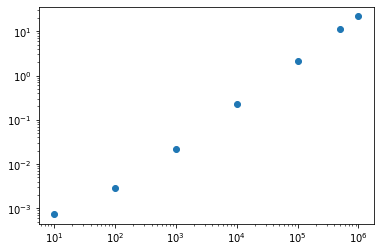

In [74]:
time_dict = {"n_bb":[],"time":[]}
for n_bb in [10,100,1000,10000,100000,500000,1000000]:
    bb = torch.Tensor([np.array([16,16,3,40,40,18]) + np.random.randint(0,10,6) for _ in range(n_bb)])
    scores = torch.Tensor(np.random.uniform(0,1,size=[n_bb]))
    #bb = torch.Tensor([[16,16,3,32,32,6],[24,24,4,48,48,8]])
    #scores = torch.Tensor([0.8,0.9])
    a = time.time()
    bb_ = nms_nd(bb,scores,score_threshold=0.5,iou_threshold=0.75)
    b = time.time()

    print(n_bb,b-a)
    time_dict["n_bb"].append(n_bb)
    time_dict["time"].append(b-a)

plt.scatter(time_dict["n_bb"],time_dict["time"])
plt.xscale('log')
plt.yscale('log')

#### Comparison with the Torchvision implementation for 2D

The native Torchvision implementation beats this by approximately 20-fold, making it the ideal case for 2D object detection. However, given that there is nothing available for 3D or above I will have to stick with this slow implementation for now during inference.

Same indices: tensor(True)
10 0.0024077892303466797 0.0001723766326904297
Same indices: tensor(True)
100 0.007436037063598633 0.00035190582275390625
Same indices: tensor(True)
1000 0.045873403549194336 0.0004324913024902344
Same indices: tensor(True)
10000 0.09157681465148926 0.0022547245025634766
Same indices: tensor(True)
100000 0.5478453636169434 0.02693486213684082
Same indices: tensor(False)
500000 2.4243459701538086 0.26449012756347656


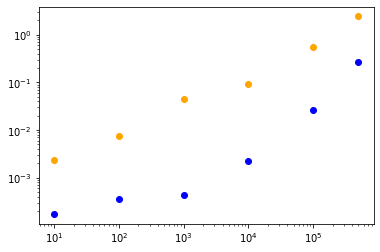

In [69]:
time_dict = {"n_bb":[],"time_nms_nd":[],"time_nms":[]}
for n_bb in [10,100,1000,10000,100000,500000]:
    bb = torch.Tensor([np.array([16,16,40,40]) + np.random.randint(0,10,4) for _ in range(n_bb)])
    scores = torch.Tensor(np.random.uniform(0,1,size=[n_bb]))
    #bb = torch.Tensor([[16,16,3,32,32,6],[24,24,4,48,48,8]])
    #scores = torch.Tensor([0.8,0.9])
    a = time.time()
    bb_1 = nms_nd(bb,scores,score_threshold=0.,iou_threshold=0.75)
    b = time.time()

    c = time.time()
    bb_2 = torchvision.ops.nms(bb,scores,iou_threshold=0.75)
    d = time.time()

    print("Same indices:",torch.all(bb_1==bb_2))

    print(n_bb,b-a,d-c)
    time_dict["n_bb"].append(n_bb)
    time_dict["time_nms_nd"].append(b-a)
    time_dict["time_nms"].append(d-c)

plt.scatter(time_dict["n_bb"],time_dict["time_nms_nd"],color="orange")
plt.scatter(time_dict["n_bb"],time_dict["time_nms"],color="blue")
plt.xscale('log')
plt.yscale('log')